# Assessing the 2022 Fire Season
The task, as I understand it, is to answer the question: Will the 2022 fire season be worse than normal?

## First, A Theory Informed High Level Answer
My understanding of fire science is that there are a few main factors which fuel the fire season:
1. Temperatures (hot temperatures lead to more fires) 
2. Fuel Availability (biomass that can burn)
3. Precipitation and Dryness (how combustible is the biomass)
4. Wind (which fans the flames)

(There are a few others, such as lightning activity which can increase fires, etc)

The National Wildlife Coordinating Group's [Fire Climate Region publication](https://www.nwcg.gov/publications/pms425-1/fire-climate-regions) is a fairly comprehensive source for understanding the US fire season. As they describe, it generally makes more sense to talk about a fire season being abnormal or unremarkable across a region, since different regions experience different climatalogical patterns: rainfall, temperature, etc. Larger climatological phenonema like La Nina affect different regions differently.

This is probably why the [National Significant Wildland Fire Potential Outlook](https://www.predictiveservices.nifc.gov/outlooks/outlooks.htm), which is a good source of fire potential over the next few months, chooses to break up fire hazard in the US in 10 regions.

When we think about US fire season, **one key piece of information to note** is that across much of the US -- the Northwest, California, Alaska, the Rocky Mountains -- peak fire season extends from June or July to September or October. Some other parts of the country -- the Great Plains, Great Lakes region, North Atlantic, the South -- have peaks in the Spring and Fall. Notably, the Southwest has peaks in May and June. Of course, with climate change and as a result of fire supression, fire seasons are getting longer and more intense.

In 2022 there have been more fires and acreage burned than in the last 10 years. However, in much of the US, including the Northwest, Alaska, and the Midwest, fire season has been near or below normal. Much of the abnormal fire activity has been in the Southwest, where an earlier dry season coincided with strong spring winds and higher than normal biomass because of above average precipitation (and vegetation growth) last winter. According to the Outlook, year-to-date acres burned for the US is approximately 112% above the 10-year average, with nearly 88% of the total acres burned from the Southwest and Southern Areas.

So while the 2022 season has been the most extensive fire season to date in the past 10 years, this is largely because parts of the Southwest and South have seen exceptionally severe fire years. But this doesn't necessarily tell us much about how the rest of the country will be in peak fire season. For example, in Washington state, the [Department of Natural Resources is expecting](https://www.king5.com/article/news/local/wildfire/2022-wildifire-season-washington-outlook/281-c104b571-276e-49a4-b814-a80d0a0bd5d8) a "normal" fire season this year. [Cal Fire](https://www.fire.ca.gov/incidents/2022/) is expecting an above normal season partly due to extended drought conditions across the state. The National Significant Wildand Fire Potential Outlook does suggest above normal conditions in much of the country in late summer and fall, but it may be less severe than last year, which had a much slower start to the fire season.

**So a high level answer to the questions above, before even looking to closely at the year-to-date data, is that it probably doesn't make the most physical sense to make country level statements about the 2022 fire year. It would make more sense to offer regional statements.**

## Data Sources
The [year-to-date estimates website](https://www.nifc.gov/fire-information/nfn) only offers data for 10 years. For my analysis, I wanted more granular data and also wanted to find out how the year-to-date data compares with total yearly burn data. So, I took annual statistics from NIFC(https://www.nifc.gov/fire-information/statistics/wildfires) and also found more granular monthly data at a [NOAA webpage]('https://www.ncdc.noaa.gov/societal-impacts/wildfires/month/0/data.csv'). It would have been nice to find more granular daily or weekly data if possible, but didn't find that.

**Key assumption: For my analysis, I primarily use acreage burned. I figure this is probably a more relevant statistic than number of fires when we think of how bad a fire season is, but I'm actually not sure whether this is correct. It wouldn't be too difficult, however, to repeated the analysis for both of these variables.**

In [1]:
# begin my importing necessary packages
import requests

import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from sklearn import linear_model

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib import font_manager
from matplotlib import rcParams

# National Interagency Fire Center urls
YEAR_TO_DATE_URL = 'https://www.nifc.gov/fire-information/nfn'
YEAR_TOTAL_URL = 'https://www.nifc.gov/fire-information/statistics/wildfires'
MONTHLY_URL = 'https://www.ncdc.noaa.gov/societal-impacts/wildfires/month/0/data.csv'

### Scrape data from NIFS website

In [2]:
def scrape_year_to_date_wildfire_data(url=YEAR_TO_DATE_URL):
  """
  Scrape year to date fire data from National Interagency Fire Center
  and return dataframe
  """
  
  website = requests.get(url)
  soup = BeautifulSoup(website.content, 'html.parser')
  table = soup.find(id='year-to-date')
  
  years = []
  fires = []
  acres = []

  for child in table.descendants:
    if child.name == 'td':
      text = child.text
      split = text.split()
      if text.startswith('2'):
        years.append(split[0])
      elif text.startswith('Fires:'):
        fires.append(split[1])
      elif text.startswith('Acres:'):
        acres.append(split[1])

  data = {'fires':fires, 'acres':acres}
  df = pd.DataFrame(data, index=years)
  df.index.name='year'
  
  df.index = df.index.astype(int)
  df['acres'] = df['acres'].str.split(',').str.join('').astype(int)
  df['fires'] = df['fires'].str.split(',').str.join('').astype(int)
  
  return df


def scrape_year_total_wildfire_data(url=YEAR_TOTAL_URL):
  """
  Scrape year total fire data from National Interagency Fire Center
  and return dataframe
  """
  
  website = requests.get(url)
  soup = BeautifulSoup(website.content, 'html.parser')
  table = soup.find(class_='table')
  
  years = []
  fires = []
  acres = []
  
  for child in table.descendants:
    if child.name == 'td':
      text = child.text
      if (len(text) == 4 and text[:1].isdigit()):
        years.append(text)
      elif len(text) == 6:
        fires.append(text)
      elif len(text) == 9 or len(text) == 10:
        if text[:1] == '*':
          acres.append(text[1:])
        else:
          acres.append(text)

  data = {'fires':fires, 'acres':acres}
  df = pd.DataFrame(data, index=years)
  df.index.name='year'
  
  df.index = df.index.astype(int)
  df['acres'] = df['acres'].str.split(',').str.join('').astype(int)
  df['fires'] = df['fires'].str.split(',').str.join('').astype(int)
  
  return df

### Download data from NOAA website

In [3]:
def get_monthly_wildfire_data(url=MONTHLY_URL):
  """
  Get monthly wildfire data from National Centers for Environmental
  Information website and return dataframes of monthly acres burned and
  fires counted
  see more at: https://www.ncdc.noaa.gov/societal-impacts/wildfires/month/0
  """
  # download data
  df = pd.read_csv(MONTHLY_URL, skiprows=1)

  # clean: replace column names, create month and year indices
  del df['Acres Burned per Fire']
  df.columns = ['date', 'acres', 'fires']
  df['date'] = pd.to_datetime(df['date'], format='%Y%m')
  df['year'] = df['date'].dt.year
  df['month'] = df['date'].dt.month
  df.set_index(['year', 'month'], inplace=True)
  del df['date']

  monthly_acres = df.unstack()['acres'].T
  monthly_fires = df.unstack()['fires'].T
  
  return monthly_fires, monthly_acres

In [4]:
to_date = scrape_year_to_date_wildfire_data()
total = scrape_year_total_wildfire_data().loc[2021:2000].iloc[::-1]
monthly_fires, monthly_acres = get_monthly_wildfire_data()
cumulative_monthly_acres = monthly_acres.cumsum()
cumulative_monthly_fires = monthly_fires.cumsum()

### Sanity check
I tested whether the monthly data and the annual data matched, and if the cumulative data from 2022 roughly matched the year-to-date data. Turns out the data doesn't always match, but the differences are relatively small enough for the analysis to still be robust. Would be interesting to find why the data doesn't always match.

In [5]:
total['acres'] - cumulative_monthly_acres.loc[12, :2021]

year
2000         0.0
2001         0.0
2002         0.0
2003         0.0
2004         0.0
2005         0.0
2006         0.0
2007         0.0
2008         0.0
2009         0.0
2010         0.0
2011         0.0
2012    104599.0
2013     12370.0
2014      8052.0
2015         0.0
2016     63475.0
2017    245024.0
2018    184883.0
2019     34357.0
2020   -152343.0
2021    -14070.0
dtype: float64

Comparing year to data data from June 17th and year-to-date data from May 31st shows that the data roughly matches, but the discrepancies do show that June is a pretty key fire month. Had I been able to get daily or weekly data, my cumulative acreage analysis below would probably have been more accurate

In [6]:
cumulative_monthly_acres.loc[5, 2012:2021]

year
2012     710661.0
2013     247787.0
2014     721221.0
2015     397136.0
2016    1597983.0
2017    2233125.0
2018    1684097.0
2019     332791.0
2020     385712.0
2021     680436.0
Name: 5, dtype: float64

In [7]:
to_date[::-1]['acres']

year
2012    1072121
2013     497181
2014     809968
2015     519609
2016    1874473
2017    2512806
2018    2142488
2019     464109
2020     936861
2021    1030343
2022    2990255
Name: acres, dtype: int64

## Analysis
My hypothesis, based on my understanding of wildfire theory, is that is is probably too early to say much about the 2022 wildfire season. One basic statistical test to confirm this is to see how well the year-to-date data in the past 20 years explains the variance in the annual cumulative acreage burned.

To use a larger sample size (the monthly data from NOAA), I'll assume that the fire data at the end of May of each year is the year-to-date data.

In [8]:
y = total['acres'].values
x = cumulative_monthly_acres.loc[5, :2021].values

First, lets plot these two variables together. As we can see below, there doesn't seem to be an obvious linear relationship between the data.

Text(0, 0.5, 'Total annual acreage burned')

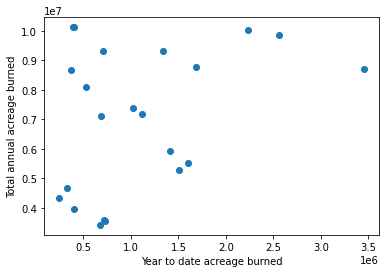

In [9]:
fig, ax = plt.subplots()
ax.scatter(x, y)
ax.set_xlabel('Year to date acreage burned')
ax.set_ylabel('Total annual acreage burned')

We can now try fitting a linear regression model, with acres burned at the end of may being the independant variable, total annual acres burned being the dependant variable.

In [10]:
lm = linear_model.LinearRegression() 
lm.fit(x.reshape(-1, 1), y.reshape(-1, 1)) # fitting the model

LinearRegression()

As we would have guessed, the R2 of this linear fit is quite low

In [11]:
lm.score(x.reshape(-1, 1), y.reshape(-1, 1))

0.11993267661193718

This quick statistical test confirms the guess I would have made based on my understanding of how wildfires work across the US, that it is hard to predict how extensive total annual wildfire acreage burned will be based on the year-to-date acreage statistics.

## Publication Ready Chart

To show that the 2022 fire season has been off to an unusually fierce start but that it is probably too early to tell in a way that makes sense to a public audience, I decided to chart the cumulative acres burned throughout the year since 2000. This way, we can compare years that had similar starts to 2022, and years that had slower starts. I tend to think this is a more publicly accessible way of visualizing than showing statistical plots.

In [12]:
def gristify_plot():
  """
  Add grist brand styles to the plot
  Note: My best estimation of the colors, styles, etc.
  """

  # Add every font at the specified location
  font_dir = ['/Users/tushar/Library/Fonts']
  for font in font_manager.findSystemFonts(font_dir):
    # use font_manager.FontProperties(fname=font).get_name() to get the name
    font_manager.fontManager.addfont(font)

  # Set font family globally
  rcParams['font.family'] = 'Open Sans'
  
  # set global style parameters
  rcParams['xtick.labelcolor'] = '#666666'
  rcParams['ytick.labelcolor'] = '#666666'
  rcParams['grid.color'] = '#ffffff'
  rcParams['axes.facecolor'] = '#eeeeee'
  rcParams['figure.facecolor'] = '#eeeeee'
  rcParams['axes.labelcolor'] = '#666666'

In [13]:
def publication_ready_chart():
  """
  Plot and save publication ready chart of cumulative fire acres burned
  between 2020 and 2022
  """

  # set global style parameters
  rcParams['xtick.labelsize'] = 20
  rcParams['ytick.labelsize'] = 20
  rcParams['grid.linewidth'] = 1
  rcParams['axes.labelsize'] = 20
  rcParams['figure.figsize'] = (14, 9)
  rcParams['figure.dpi'] = 300

  # plot figure
  fig, ax = plt.subplots()
  for column in cumulative_monthly_acres.columns:
    if column == 2020:
      color = 'blue'
      ax.plot(cumulative_monthly_acres[column], label=column, color=color, linewidth=3)
    elif column == 2016:
      color = 'red'
      ax.plot(cumulative_monthly_acres[column], label=column, color=color, linewidth=3)
    elif column == 2015:
      color = 'green'
      ax.plot(cumulative_monthly_acres[column], label=column, color=color, linewidth=3)
    elif column == 2017:
      color = 'orange'
      ax.plot(cumulative_monthly_acres[column], label=column, color=color, linewidth=3)
    elif column == 2022:
      color = 'purple'
      ax.plot(cumulative_monthly_acres[column], label=column, color=color, linewidth=3)
    else:
      color = 'grey'
      ax.plot(cumulative_monthly_acres[column], label=column, color=color, alpha=0.3)

  # set tick styles and labels
  ax.tick_params(left=False, bottom=False)
  ax.set_xticks(cumulative_monthly_acres.index)
  ax.set_xticklabels(pd.to_datetime(cumulative_monthly_fires.index, format='%m').month_name().str[:3])
  ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1e8, decimals=0, symbol=' M', is_latex=False))

  # add a grid
  ax.grid(visible=True, which='major', axis='y')
  ax.set_axisbelow(True)

  # clear spines
  ax.spines['right'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.spines['top'].set_visible(False)

  # title
  ax.text(s='Millions of Acres Burned in US wildfires from 2000-2022', fontsize=30, y=1.22, x=-0.06,
          transform=ax.transAxes, fontweight=600)
  ax.text(s='While 2022 wildfires have been off to a fast start, we still haven\'t hit peak fire season yet.',
          fontsize=20, y=1.15, x=-0.06,transform=ax.transAxes, fontweight=100)
  ax.text(s='2020 and 2015, two of the worst years, started much slower. Some years that started early,',
          fontsize=20, y=1.09, x=-0.06,transform=ax.transAxes, fontweight=100)
  ax.text(s='like 2017, made the record books while others, like 2016, were below average.',
          fontsize=20, y=1.03, x=-0.06,transform=ax.transAxes, fontweight=100)
  ax.text(s='Data Source: National Interagency Fire Center', fontsize=15, y=-0.12, x=-0.06, transform=ax.transAxes, fontweight=100)
  ax.text(s='2022', fontsize=20, y=1.15, x=0.01, transform=ax.transAxes, fontweight=600, color='purple')
  ax.text(s='2020', fontsize=20, y=1.09, x=-0.06, transform=ax.transAxes, fontweight=600, color='blue')
  ax.text(s='2015', fontsize=20, y=1.09, x=0.056, transform=ax.transAxes, fontweight=600, color='green')
  ax.text(s='2017', fontsize=20, y=1.03, x=-0.015, transform=ax.transAxes, fontweight=600, color='orange')
  ax.text(s='2016', fontsize=20, y=1.03, x=0.5285, transform=ax.transAxes, fontweight=600, color='red')
  
  # set figure limits
  ax.set_xlim(0.8, 12)

  # create filename and save
  filename = 'acres-burned'
  fig.savefig('figures/' + filename + '.jpg', bbox_inches='tight', pad_inches=0.3)

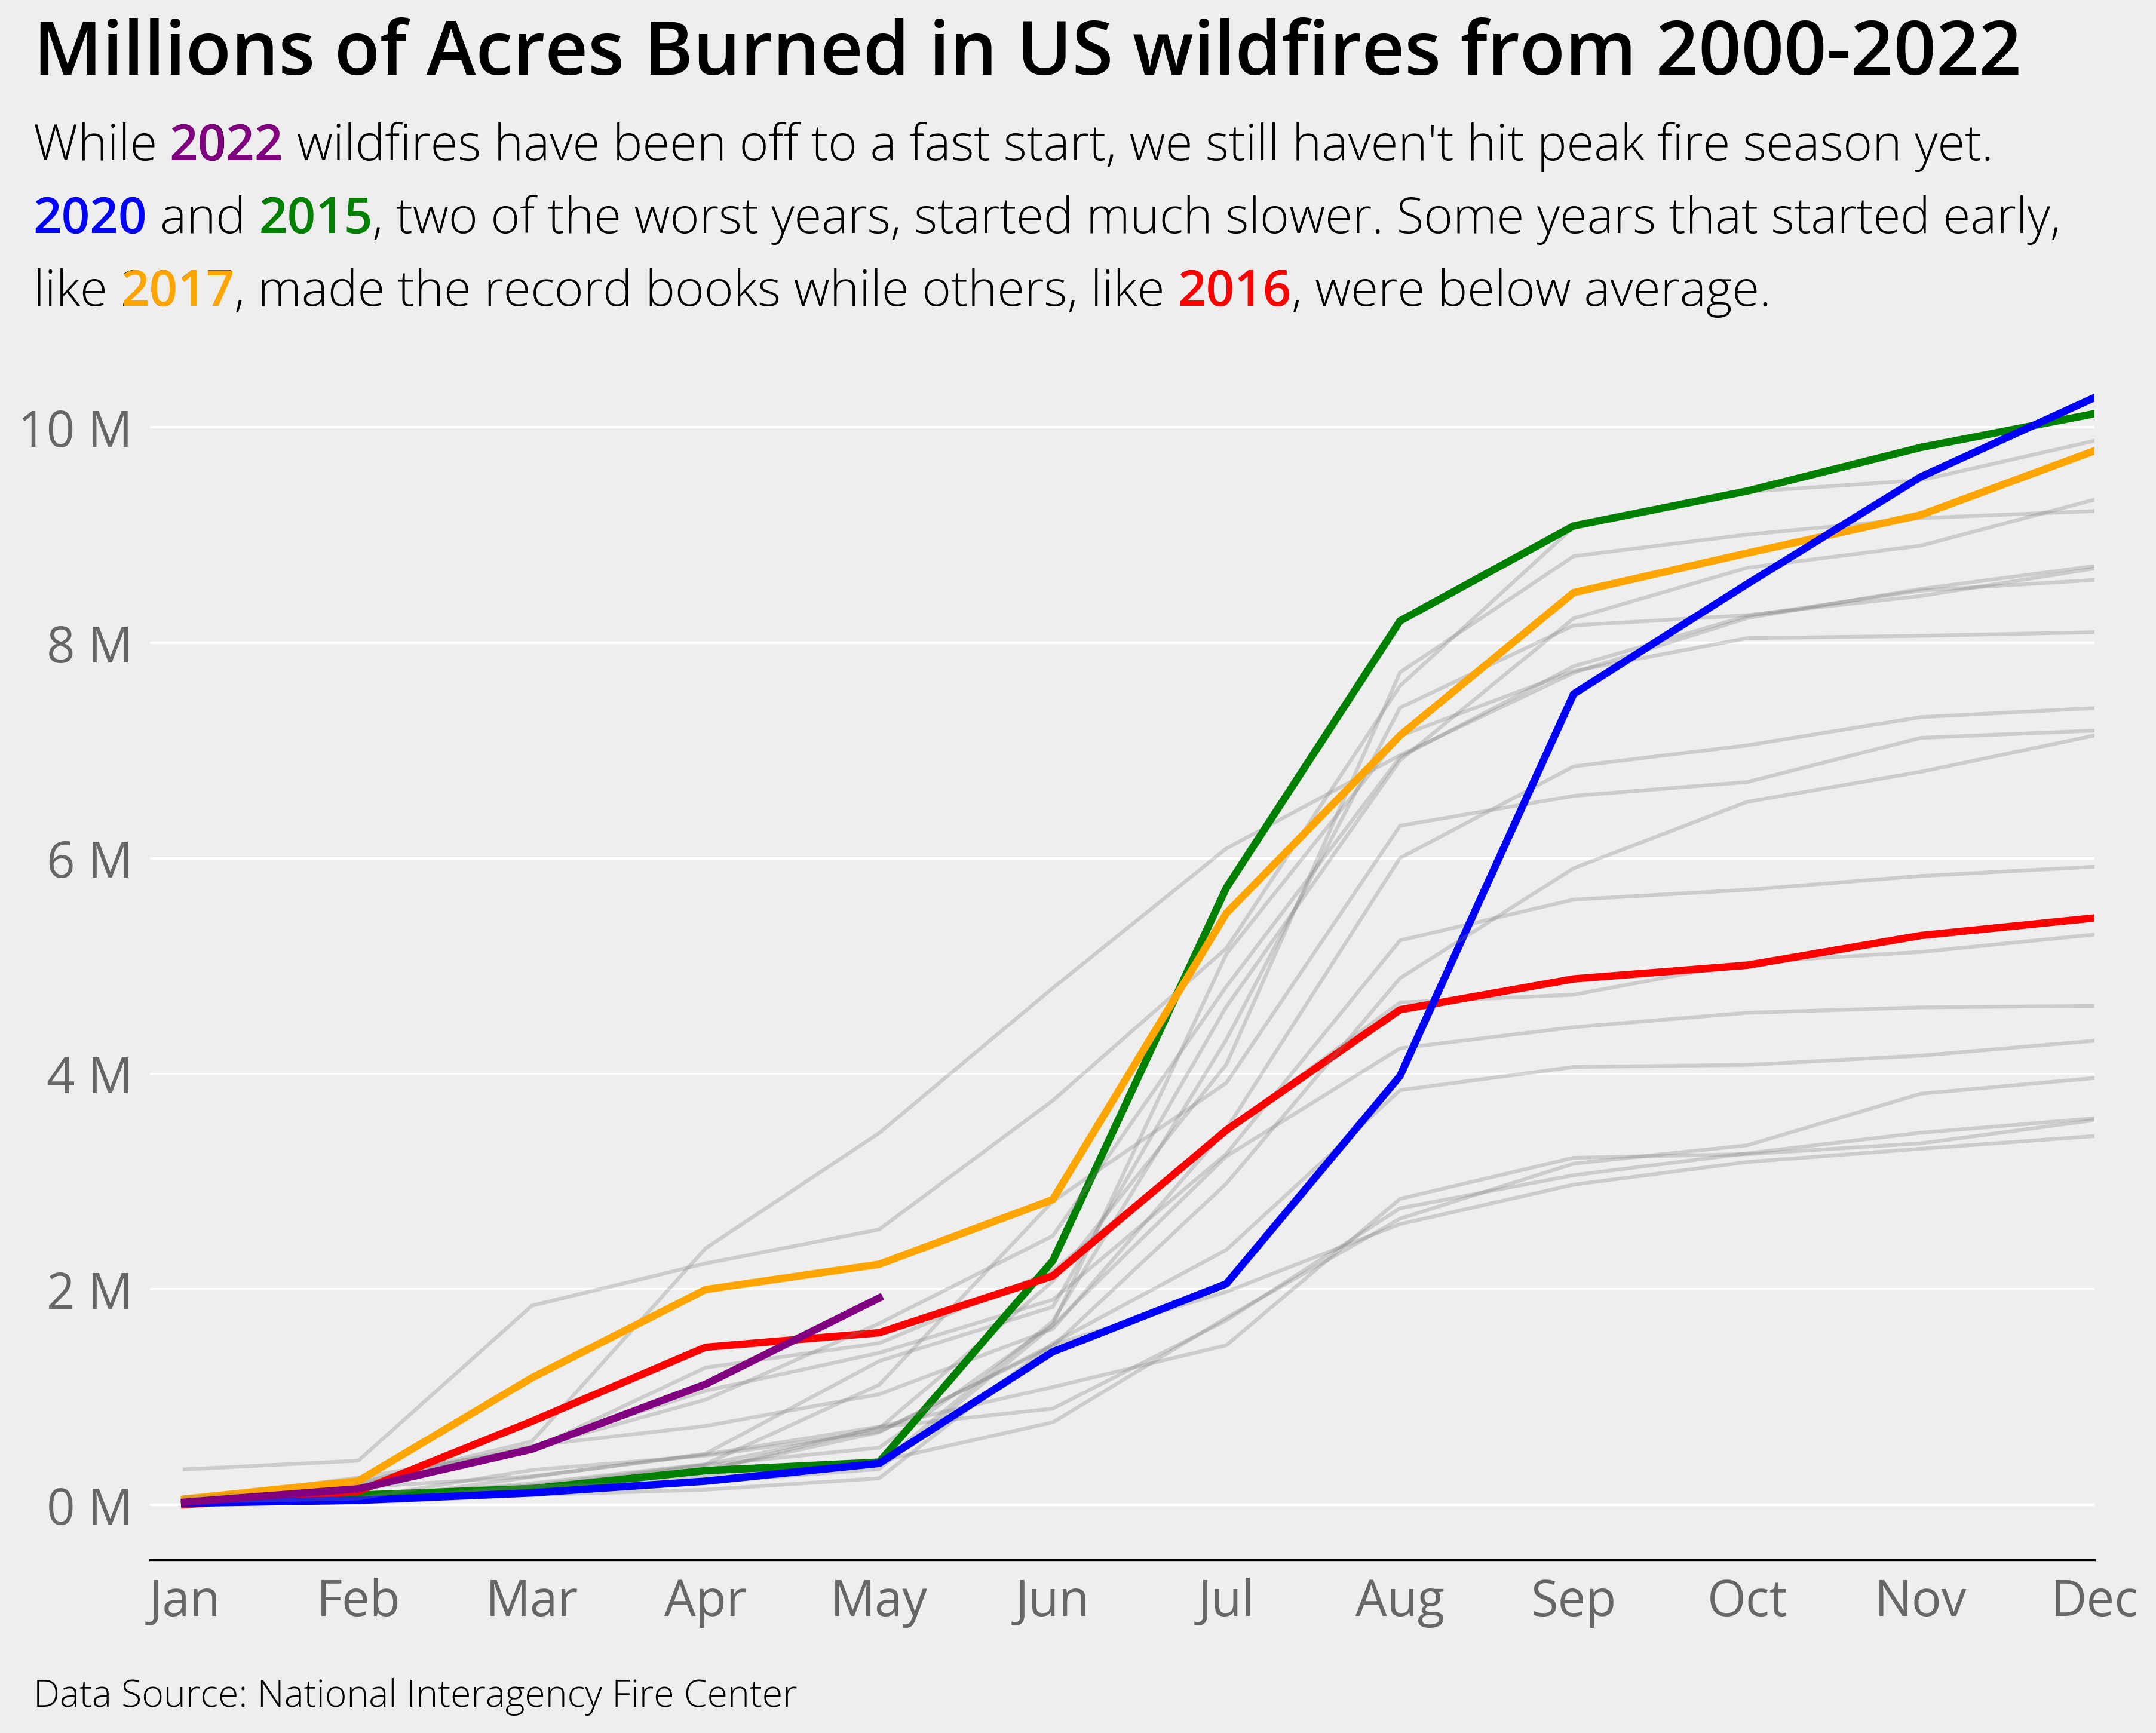

In [14]:
gristify_plot()
publication_ready_chart()

## Paragraph to go with the chart

Wildfires are off to an exceptionally fast start in 2022. In the last 20 years, only 2006 and 2011 saw larger acreages burned this early in the year. Intense early seasons in the Southwest and Southeast have fueled the inferno, accounting for 88% of the total acreage burned. Nevertheless, peak wildfire season in much of the country is yet to arrive, and federal agencies remind us that regional variations in temperatures, combustible biomass, wind patterns, and rainfall make it difficult to say whether this trend will continue. While prolonged drought conditions have Californian's worried, other state agencies are hoping that this year will bring fewer fires than 2021. 2022 was certainly a record-breaking wildfire year for New Mexico, but it is probably too early to say whether the season will continue to be exceptional throughout the year and in the rest of the country.